In [1]:
import wisps
import numpy as np
import matplotlib.pyplot as plt
import wisps.simulations as wispsim
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from matplotlib.colors import Normalize
import astropy.units as u 
import wisps.simulations.effective_numbers as eff
import seaborn as sns
import matplotlib
import popsims
import itertools
#plt.style.use('dark_background')


%matplotlib inline

Adding 145 sources from /Users/caganze/research/splat//resources/Spectra/Public/LRIS-RED/ to spectral database
Adding 2404 sources from /Users/caganze/research/splat//resources/Spectra/Public/SPEX-PRISM/ to spectral database
Adding 89 sources from /Users/caganze/research/splat//resources/Spectra/Public/MAGE/ to spectral database


In [2]:
import popsims
import splat

In [3]:
sgrid=wispsim.SPGRID
pnts=pd.read_pickle(wisps.OUTPUT_FILES+'/pointings_correctedf110.pkl')
corr_pols=wisps.POLYNOMIAL_RELATIONS['mag_limit_corrections'] 
klf=pd.read_csv('/users/caganze/research/wisps/data/kirkpatricklf.txt', delimiter=',')
klf['bin_center']=np.mean(np.array([klf.t0.values, klf.tf.values]), axis=0)
klf=klf.replace(0.0,np.nan)

cands=pd.read_pickle(wisps.LIBRARIES+'/real_ucds.pkl')
cands=cands[(cands.spt >=17) & (cands.snr1>=3)].reset_index(drop=True)
tab=wisps.Annotator.reformat_table(cands)
pnt_names=[x.name for x in pnts]

In [4]:
#

In [5]:
#cmap= sns.color_palette("coolwarm", 8, as_cmap=True)
cmap=matplotlib.cm.get_cmap('coolwarm')
cnorm=Normalize(wispsim.HS[0], (wispsim.HS[-1]))

In [6]:
kirkpatrick2020LF={'bin_center':np.flip(np.array([2025, 1875, 1725, 1575, 1425, 1275, 1125 , 975, 825, 675, 525])), 
                   'values':np.flip(np.array([0.72, 0.50,0.78, 0.81,0.94, 1.95, 1.11, 1.72, 1.99, 2.80, 4.24])), 
                   'unc':np.flip(([0.18, 0.17, 0.20,0.20, 0.22, 0.3, 0.25, 0.3, 0.32, 0.37, 0.70]))}


In [7]:
def bin_by_spt_bin(sp_types, number, ltonly=False):
    ranges=[[17, 20], [20, 25], [25, 30], [30, 35], [35, 40]]
    if ltonly:
        ranges=[[17, 20], [20, 30], [30, 41]]
    numbers=[]
    for r in ranges:
        idx= np.logical_and((r[0]<=sp_types), (r[1]>sp_types))
        numbers.append(np.nansum(number[idx]))
    return numbers

def get_all_numbers():
    #Distribute the parameter sets evenly across the cores
    func=lambda x, y:  get_simulated_number_model(y, x)

    paramlist=[(i, j)  for i, j in itertools.product(['saumon2008', 'burrows2001', 'baraffe2003', 'marley2019', 'phillips2020'], wispsim.HS)]
    res  = [func(x, y) for x,y in tqdm(paramlist)]
    
    nbrs = {}
    for k in ['saumon2008', 'marley2019', 'phillips2020', 'burrows2001', 'baraffe2003']:
        ds0={}
        for j in res:
            if k in j.keys():
                key=[x for x in j[k].keys()][0]
                ds0.update({key: [(j[k][key])[yi] for yi in wispsim.SPGRID]})
        #print (ds0)
        nbrs[k]=np.array([ds0[k] for k in wispsim.HS])

    return nbrs
    


def get_pointing(grism_id):
    if grism_id.startswith('par'):
        pntname=grism_id.lower().split('-')[0]
    else:
        pntname=grism_id.lower().split('-g141')[0]
    loc=pnt_names.index(pntname)
    return np.array(pnts)[loc]


def iswithin_mag_limits(mags, pnt, spt):
    #mgs is a dictionary
    flags=[]
    for k in pnt.mag_limits.keys():
        if k =='F110' and pnt.survey =='hst3d':
            flags.append(True)
        else:
            flags.append(mags[k] <= pnt.mag_limits[k]+ (corr_pols[k+'W'][0])(spt))
    return np.logical_or.reduce(flags)

def scale_lf_teff(teffs):
    binedges= np.append(kirkpatrick2020LF['bin_center']-75, kirkpatrick2020LF['bin_center'][-1]-75)
    bools=np.logical_and(teffs <= binedges[-1], teffs >= binedges[0])
    preds=np.histogram(teffs, bins=binedges, normed=False)[0]
    
    obs=np.array(kirkpatrick2020LF['values'])
    unc=np.array(kirkpatrick2020LF['unc'])
    
    obs_monte_carlo= np.random.normal(obs, unc, (10000, len(obs)))
    pred_monte= np.ones_like(obs_monte_carlo)*(preds)
    unc_monte=  np.ones_like(obs_monte_carlo)*(unc)
    
    
    
    #unc_monte= 
    scale=(np.nansum((obs_monte_carlo*pred_monte)/(unc_monte**2), axis=1)\
           /np.nansum(((pred_monte**2)/(unc_monte**2)), axis=1))*(10**-3)
    
    
    
    #fig, ax=plt.subplots()
    #ax.step(kirkpatrick2020LF['bin_centertw'], preds*scale*(10**-3), where='mid')
    #x.errorbar(kirkpatrick2020LF['bin_center'], np.array(kirkpatrick2020LF['values'])*(10**-3),
    #         yerr= np.array(kirkpatrick2020LF['unc'])*(10**-3), fmt='o', color='#111111')
    return [np.nanmedian(scale), np.nanstd(scale), len(teffs)]
def get_simulated_number_model(hidx, model):
    #hidx is a scale height, model is evolutionary model
    cutdf=pd.read_hdf(wisps.OUTPUT_FILES+'/final_simulated_sample_cut.h5', key=str(model)+str('h')+str(hidx)+'F110_corrected')
    scl_dict=pd.read_pickle(wisps.OUTPUT_FILES+'/lf_scales.pkl') 
    scale=scl_dict[model]
    #scale=scale_lf_teff(cutdf.teff)
    NSIM=dict(zip(wispsim.SPGRID,np.zeros((len(wispsim.SPGRID), 2))))
    cutdf['spt_r']=cutdf.spt.apply(np.round)
    for g in cutdf.groupby('spt_r'):
        sn= len(cutdf.teff[np.logical_and(cutdf.teff>=450, cutdf.teff<=1950)])
        n0=scale[-1]/scale[0]
        #print (n0)
        scln=np.array([scale[0]*n0/sn,\
                       (scale[1]*scale[-1])/(sn*scale[0])])
        #scln=np.array(scale)
        #assert scln[0] > scale[0]
        NSIM[g[0]]=np.nansum(g[1].sl)*scln
    del cutdf
    return {model: {hidx:NSIM}}


def plot(NUMBERS, VOLUMES, filename='/oberved_numbers.pdf'):
    # In[ ]:
    nall=wisps.custom_histogram(cands.spt.apply(wisps.make_spt_number), sgrid, 1)
    
    y2=bin_by_spt_bin(wispsim.SPGRID,nobs, ltonly=False)-THICK
    yall=bin_by_spt_bin(wispsim.SPGRID,nall, ltonly=False)
    
    dy2=np.sqrt(y2)
    dyall=np.sqrt(yall)

    fig, ax=plt.subplots(figsize=(14, 8), ncols=3, nrows=2, sharey=False, sharex=False)
    
    for model, a in zip(['burrows2001', 'baraffe2003', 'saumon2008', 'marley2019', 'phillips2020'], np.concatenate(ax)):
        
        for idx, h in enumerate(wispsim.HS):
            
            ns=None
            ns=((NUMBERS[model])[idx])[:,0]*VOLUMES[idx]
            nuncs=((NUMBERS[model])[idx])[:,1]*VOLUMES[idx]
            
            a.plot(spgrid2, bin_by_spt_bin(wispsim.SPGRID,ns, ltonly=False), 
                          color= cmap(cnorm(h)), 
                   linewidth=3, drawstyle="steps-mid")
            a.fill_between(spgrid2, bin_by_spt_bin(wispsim.SPGRID,ns+nuncs, ltonly=False),  
                           bin_by_spt_bin(wispsim.SPGRID,ns-nuncs, ltonly=False), alpha=0.5, 
                           color= cmap(cnorm(h/100)),  step="mid")
        
        a.set_yscale('log')
        a.errorbar(spgrid2,y2, yerr=dy2,fmt='o', color='#111111')
        a.errorbar(spgrid2,yall, yerr=dyall,color='#B10DC9', mfc='white', fmt='o')
        a.set_xlabel('SpT',fontsize=18)
        a.set_ylabel('N',fontsize=18)
        a.minorticks_on()
            


   
    ax[0][0].set_title('Model= B01', fontsize=18)
    ax[0][1].set_title('Model= B03', fontsize=18)
    ax[0][2].set_title('Model= SM08', fontsize=18)
    ax[1][0].set_title('Model= M19', fontsize=18)
    ax[1][1].set_title('Model= P20', fontsize=18)

    ax[1][-2].errorbar(spgrid2,y2, yerr=dy2,fmt='o', label='Mag Limited', color='#111111')
    ax[1][-2].errorbar(spgrid2,yall, yerr=dyall,color='#B10DC9', fmt='o', mfc='white', label='All Observations')
    
    #ax[-1][-2].legend(fontsize=14,  bbox_to_anchor=(1.05, 1), loc='upper left')
    fig.delaxes(np.concatenate(ax)[-1])
    ax[1][-2].legend( fontsize=14)
    
    cax = fig.add_axes([.675, 0.3, .3, 0.03])
    mp=matplotlib.cm.ScalarMappable(norm=cnorm, cmap='coolwarm')
    cbar=plt.colorbar(mp, cax=cax, orientation='horizontal')
    cbar.ax.set_xlabel(r'Scaleheight (H)', fontsize=18)
    #cbar.ax.set_yticks([1, 3, 5, 10])
    #np.concatenate(ax)[-2].legend(loc='center left', bbox_to_anchor=(1, 1.5), fontsize=14)
    plt.tight_layout()
    plt.savefig(wisps.OUTPUT_FIGURES+filename, bbox_inches='tight')

In [8]:
#

In [9]:
def plot_one(NUMBERS, VOLUMES, filename='/oberved_numbers_one_panel.pdf'):
    data_to_save={}
    # In[ ]:
    nall=wisps.custom_histogram(cands.spt.apply(wisps.make_spt_number), sgrid, 1)
    
    y2=bin_by_spt_bin(wispsim.SPGRID,nobs, ltonly=False)-THICK
    yall=bin_by_spt_bin(wispsim.SPGRID,nall, ltonly=False)-THICK
    
    dy2=np.sqrt(y2)
    dyall=np.sqrt(yall)
     #add this to the dictionary
    data_to_save['nall']=nall
    data_to_save['nobs']=nobs
    data_to_save['yall']=yall
    data_to_save['y2']=y2

    fig, a=plt.subplots(figsize=(8, 6))
    
    #for model, a in zip(['baraffe2003', 'saumon2008', 'marley2019', 'phillips2020'], np.concatenate(ax)):
    model='baraffe2003'
    for idx, h in enumerate(wispsim.HS):
            
            ns=None
            ns=((NUMBERS[model])[idx])[:,0]*VOLUMES[idx]
            nuncs=((NUMBERS[model])[idx])[:,1]*VOLUMES[idx]
            
            a.plot(spgrid2, bin_by_spt_bin(wispsim.SPGRID,ns, ltonly=False), 
                          label='h={} pc'.format(h), color= cmap(cnorm(h/100)), 
                   linewidth=3, drawstyle="steps-mid")
            a.fill_between(spgrid2, bin_by_spt_bin(wispsim.SPGRID,ns+nuncs, ltonly=False),  
                           bin_by_spt_bin(wispsim.SPGRID,ns-nuncs, ltonly=False), alpha=0.5, 
                           color= cmap(cnorm(h/100)),  step="mid")
            data_to_save.update({h: bin_by_spt_bin(wispsim.SPGRID,ns, ltonly=False)})
        
    a.set_yscale('log')
    a.errorbar(spgrid2,y2, yerr=dy2,fmt='o', color='#111111')
    a.errorbar(spgrid2,yall, yerr=dyall,color='#B10DC9', mfc='white', fmt='o')
    a.set_xlabel('SpT',fontsize=18)
    a.set_ylabel('N',fontsize=18)
    a.minorticks_on()
            

    #a.set_title('Model= SM08', fontsize=18)
    a.set_title('Model= B03', fontsize=18)
    #a.set_title('Model= M19', fontsize=18)
    #a.set_title('Model= P20', fontsize=18)

    a.errorbar(spgrid2,y2, yerr=dy2,fmt='o', label='Mag Limited', color='#111111')
    a.errorbar(spgrid2,yall, yerr=dyall,color='#B10DC9', fmt='o', mfc='white', label='All Observations')
    
    a.legend(fontsize=14, loc='upper left')
    plt.tight_layout()
    plt.savefig(wisps.OUTPUT_FIGURES+filename, bbox_inches='tight',  facecolor='white', transparent=False)
    
    import pickle
    with open('/users/caganze/results.pkl', 'wb') as file:
        pickle.dump(data_to_save,file)

In [10]:
#d=pd.read_pickle(wisps.OUTPUT_FILES+'/distance_samples{}'.format(h))

In [11]:
#expectted counts from thick disk
THICK=np.array([8.79798048, 2.30571423, 0.14145726, 0.08853498, 0.01784511])

In [12]:

tab['pnt']=tab['grism_id'].apply(get_pointing)
tab['spt_val']=np.vstack(tab.spt.values)[:,0]
obsmgs=tab[['F140W', 'F110W', 'F160W']].rename(columns={"F110W": "F110", 
                                                                    "F140W": "F140",
                                                                    "F160W": "F160"}).to_dict('records')

flags=[iswithin_mag_limits(x, y, z) for x, y, z in zip(obsmgs, tab.pnt.values,tab.spt.values )]

#let's see what happens if we include all objects
#flags=np.ones(len(flags)).astype(bool)
cdf_to_use=tab[flags]

nobs=wisps.custom_histogram(cdf_to_use.spt_val.apply(wisps.make_spt_number), sgrid, 1)


spgrid2=['M7-L0', 'L0-L5', 'L5-T0', 'T0-T5', 'T5-Y0']
spgrid3=['Late M', 'L', 'T']

In [13]:
for k in ['F140', 'F110', 'F160']:
    tab['lim_{}'.format(k)]=tab.pnt.apply(lambda x: x.mag_limits[k])
    tab['detected_{}'.format(k)]= tab[k+'W'] < tab['lim_{}'.format(k)]

In [14]:
subtab=(tab[tab.spt.between(30, 35)]).reset_index(drop=True)

In [15]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    print( subtab[['F140W', 'F160W', 'lim_F140', 'lim_F160', 'detected_F140', 'detected_F160', 'grism_id',
#                  'spt']])

In [16]:
#NUMBERS=pd.read_pickle(wisps.OUTPUT_FILES+'/numbers_simulated.pkl')
NUMBERS=get_all_numbers()

100%|██████████| 65/65 [00:50<00:00,  1.28it/s]


In [17]:
#plt.hist(np.log10(NUMBERS['baraffe2003'][0][:,1]))

In [18]:
volumes=[]
for pnt in pnts:
    vs=[]
    for h in wispsim.HS:
        vsx=[]
        for g in wispsim.SPGRID:
            vsx.append((pnt.volumes[h])[g])
        vs.append(vsx)
    volumes.append(vs)
volumes=np.array(volumes)

VOLUMES=(np.nansum(volumes, axis=0))*4.1*(u.arcmin**2).to(u.radian**2)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


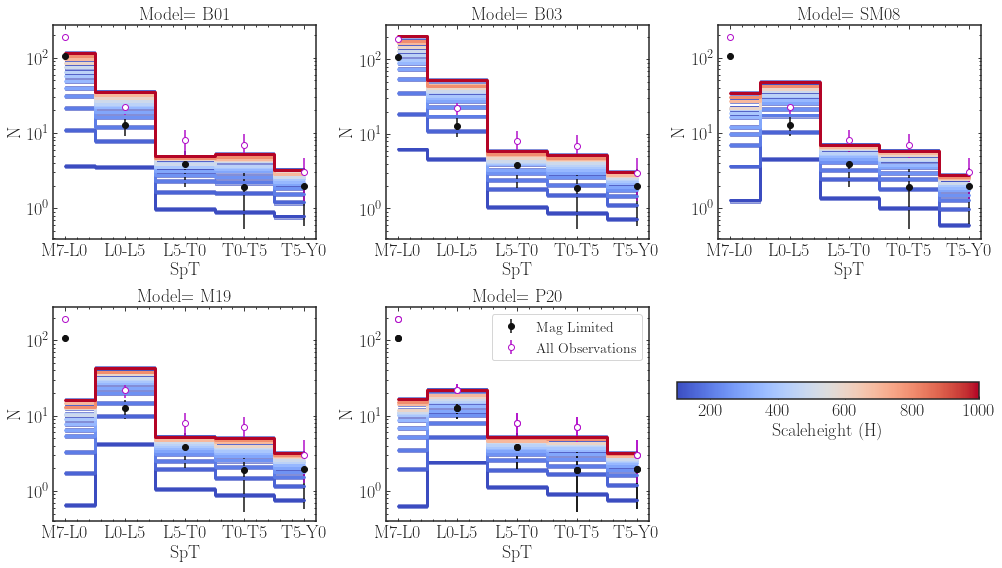

In [19]:
 plot(NUMBERS, VOLUMES, filename='/obs_numbers.pdf')

In [20]:
#plot_one(NUMBERS, VOLUMES)

In [21]:
nall=wisps.custom_histogram(cands.spt.apply(wisps.make_spt_number), sgrid, 1)
y2=bin_by_spt_bin(wispsim.SPGRID,nobs, ltonly=False)-THICK

In [22]:
def asymetric_errors(vals):
    if len(vals)<1:
        return [np.nan, np.nan]
    else:
        med= np.nanmedian(vals)
        up= np.nanpercentile(vals, 86)
        dn= np.nanpercentile(vals, 14)
        return np.array([med-dn, up-med])

In [23]:
np.nanpercentile(wispsim.HS, 10)

160.0

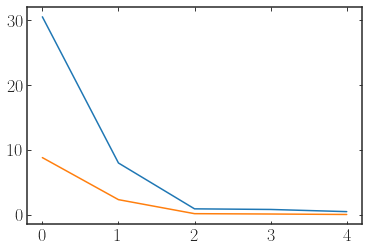

In [24]:
plt.plot(bin_by_spt_bin(wispsim.SPGRID,NUMBERS['baraffe2003'][-1][:,0]*VOLUMES[-1]*(0.12/0.8)))
plt.plot(THICK)
#THICK

In [25]:
#bin_by_spt_bin(wispsim.SPGRID,nall, ltonly=False)

In [26]:
#just for L dwarfs and T dwarfs
y3=bin_by_spt_bin(wispsim.SPGRID,nall, ltonly=False)-THICK
y4=bin_by_spt_bin(wispsim.SPGRID,nobs, ltonly=True)#-THICK
y5= np.nansum(y4)
print ('all ----- {}'.format(y3))
print ('used ----- {}'.format(y2))
print ('MLT ----{}'.format(y4))
print ('All ----{}'.format(y5))


all ----- [181.20201952  19.69428577   7.85854274   6.91146502   2.98215489]
used ----- [107.20201952  12.69428577   3.85854274   1.91146502   1.98215489]
MLT ----[116, 19, 4]
All ----139


In [27]:
#PRINT THE BEST FIT NUMBER 
#best_fit={}
numbers_fit={} #predictions for all
numbers_fit_lt={} #predictions for M, L, T
#numbers_fit_total={} #predictions for total number counts
for model in ['burrows2001', 'saumon2008', 'baraffe2003', 'marley2019', 'phillips2020']:
        model_number_lt={}
        model_number={}
        for idx, h in enumerate(wispsim.HS):
            
            ns=None
            ns=((NUMBERS[model])[idx])[:,0]*VOLUMES[idx]
            nuncs=((NUMBERS[model])[idx])[:,1]*VOLUMES[idx]
            
            binned=np.array(bin_by_spt_bin(wispsim.SPGRID,ns, ltonly=False))
            binned_lt= np.array(bin_by_spt_bin(wispsim.SPGRID,ns, ltonly=True))
            #binned_unc=np.array(bin_by_spt_bin(wispsim.SPGRID,nuncs, ltonly=False))
            #add L and 
            #compute chi-squared
            #print (ns)
            #chisq= abs((y2-binned)**2/(y2))
            #model_fit.update({h: chisq})
            #binned_total=np.append(binned, binned_lt)
            #binned_total=np.append(binned, binned_lt)
            model_number.update({h: binned})
            model_number_lt.update({h: binned_lt})
        # best_fit.update({model: model_fit})
        numbers_fit.update({model: model_number})
        numbers_fit_lt.update({model:  model_number_lt})

In [28]:
#chisq_dicts=pd.DataFrame.from_records(best_fit)
pred_number_dicts=pd.DataFrame.from_records(numbers_fit)
pred_number_lt_dicts=pd.DataFrame.from_records(numbers_fit_lt)

In [29]:
from scipy.interpolate import interp1d

In [30]:
import scipy.stats as stats

In [63]:


def get_poisson_predictions(spt_grid, obstns, predns):
    res={}
    for c in  predns.columns:
        min_vals={}
        dist={}
        #for idx,s  in enumerate(np.append(spgrid2, ['L dwarfs', 'T dwarfs'])):
        for idx,s  in enumerate(spt_grid):
            #compare between subtypes
            #predicted
            predvals=(np.vstack(predns[c].values))[:,idx]
            #observed
            nreal=  obstns[idx]
            #make an interpolation function
            #interpf = interp1d(predvals, wispsim.HS)
            #using a 2nd degree polynomial 
            interpf = np.poly1d(np.polyfit(predvals, wispsim.HS, 3))

            #draw a bunch of random values based on a poisson distribution
            #npoisson=np.random.poisson(nreal, 100000).astype(float)
            #print (nreal)
            npoisson=stats.gamma.rvs(nreal, size =int(1e5))
            #stay within the range of possible values to avoid interpolation error
            #i.e take this as a prior
            #dflag=npoisson>=vals.min()
            #uflag= npoisson <=vals.max()
            #npoisson[dflag]= vals.min()
            #npoisson[uflag]= vals.max()
            #allow extraploayion
            npoisson=npoisson[np.logical_and(npoisson>=predvals.min(), npoisson <=predvals.max())]
            #predict scale heights
            predhs=interpf(npoisson)
            #use a weighted mean and std 
            #mean, unc= (np.nanmean(predhs), np.nanstd(predhs))

            #print (' scale height for model {} and spt {} is {} +/- {} '.format(c, s, np.round(mean), np.round(unc, 4)))
            dist.update({s:predhs})
        #min_chi_ssqrs.update({c:min_vals})
        res.update({c: dist})
    return  res

In [64]:
def scaleheight_to_vertical_disp(hs):
    shape=435 #shape parameter
    sigma_68=1.
    return np.sqrt((np.array(hs))/shape)*20

def compute_age_with_z(sigmas, z):
    ag_bov= popsims.avr_yu(sigmas[abs(z) >270], verbose=True, nsample=2, height='above')[0]
    ag_bel=popsims.avr_yu(sigmas[abs(z) <=270], verbose=True, nsample=2, height='below')[0]
    return np.concatenate([ag_bov, ag_bel]).flatten()

def asssymetric_med_std(x):
    return np.round(np.nanmedian(x), 2), np.round(asymetric_errors(x), 2)

In [65]:
def avr_aumer(sigma,  direction='vertical', verbose=False):
    #return the age from an age-velocity dispersion 
    verboseprint = print if verbose else lambda *a, **k: None
    result=None
    beta_dict={'radial': [0.307, 0.001, 41.899],
                'total': [ 0.385, 0.261, 57.15747],
                'azimuthal':[0.430, 0.715, 28.823],
                'vertical':[0.445, 0.001, 23.831],
                }

    verboseprint("Assuming Aumer & Binney 2009 Metal-Rich Fits and {} velocity ".format(direction))

    beta, tau1, sigma10=beta_dict[direction]
       
    result=((sigma/sigma10)**(1/beta))*(10+tau1)-tau1

    return result

In [66]:
int(106.20201952)

106

In [67]:
scale_height_dist=get_poisson_predictions(spgrid2, y2,pred_number_dicts)
scale_height_dist_df=pd.DataFrame(scale_height_dist)
vel_df=scale_height_dist_df.applymap(scaleheight_to_vertical_disp)
age_distdf_yu=vel_df.applymap(lambda x: popsims.avr_yu(x, verbose=False, nsample=2, height='median')[0])
age_distdf_just=vel_df.applymap(lambda x: popsims.avr_just(x, verbose=False))
age_distdf_sand=vel_df.applymap(lambda x: popsims.avr_sanders(x, verbose=False))
age_distdf_aumer=vel_df.applymap(lambda x: avr_aumer(x, verbose=False))



scalh_tables=scale_height_dist_df.applymap( asssymetric_med_std)
vel_tables=vel_df.applymap(asssymetric_med_std)
age_tables_yu=age_distdf_yu.applymap( asssymetric_med_std)
age_tables_just=age_distdf_just.applymap( asssymetric_med_std)
age_tables_sand=age_distdf_sand.applymap( asssymetric_med_std)
age_tables_aumer=age_distdf_aumer.applymap( asssymetric_med_std)

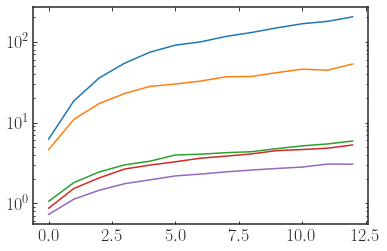

In [68]:
plt.plot(np.vstack(pred_number_dicts['baraffe2003'].values))
plt.yscale('log')

In [69]:
#obstns

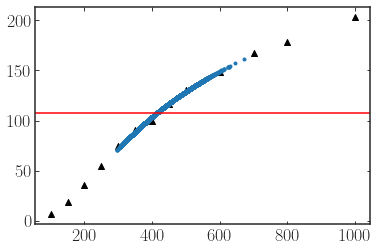

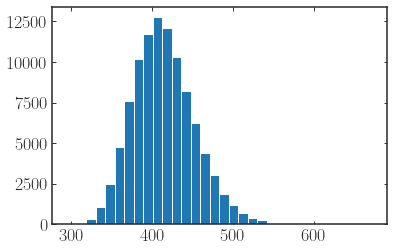

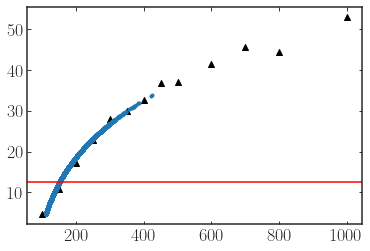

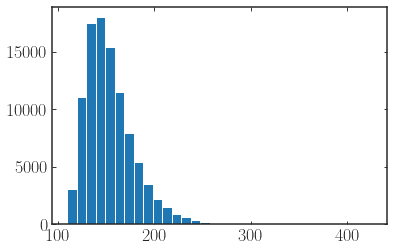

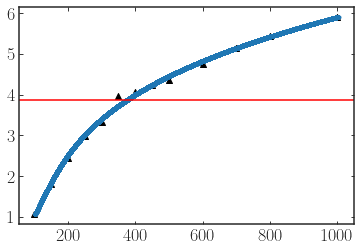

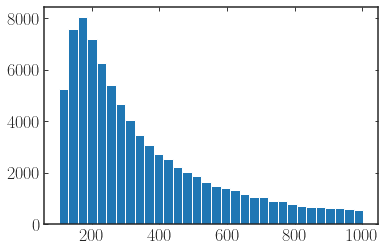

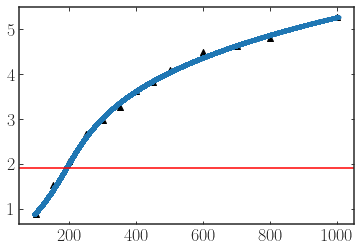

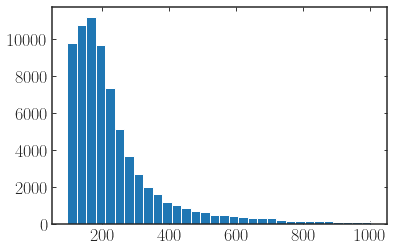

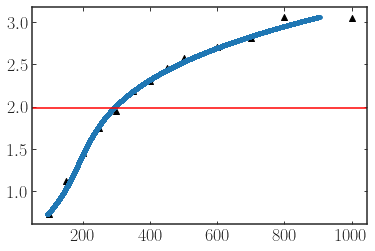

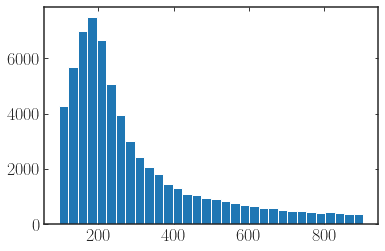

In [96]:
for idx in np.arange(len(y2)):
    predvals=(np.vstack(np.vstack(pred_number_dicts['baraffe2003'].values)))[:,idx]
    #observed

    #make an interpolation function
    interpf = np.poly1d(np.polyfit(predvals, wispsim.HS, 3))
    
    rvs=stats.gamma.rvs(y2[idx], size =int(1e5))
    rvs=rvs[np.logical_and(rvs>=predvals.min(), rvs <=predvals.max())]
    fig, ax=plt.subplots()
    plt.scatter( wispsim.HS, predvals, marker='^', color='k')
    plt.plot( interpf(rvs), rvs, '.')
    plt.axhline(y2[idx], color='r')
    #h=plt.hist(rvs, bins='auto')
    fig, ax=plt.subplots()
    h=plt.hist(interpf(rvs), bins=32)

In [71]:
#scalh_tables[['baraffe2003', 'saumon2008', 'marley2019', 'phillips2020']]

In [72]:
def reformat(val):
    return str(val[0])+'$ _{-'+str(val[1][0])+'} ^{+'+str(val[1][1])+'}$'

In [73]:
scalh_tables[['burrows2001', 'baraffe2003', 'saumon2008', \
              'marley2019', 'phillips2020']].applymap(reformat)

,burrows2001,baraffe2003,saumon2008,marley2019,phillips2020
M7-L0,809.27$ _{-115.11} ^{+112.53}$,411.76$ _{-37.36} ^{+43.85}$,nan$ _{-nan} ^{+nan}$,nan$ _{-nan} ^{+nan}$,nan$ _{-nan} ^{+nan}$
L0-L5,203.61$ _{-38.8} ^{+55.42}$,149.4$ _{-20.03} ^{+31.2}$,172.19$ _{-30.16} ^{+35.76}$,173.02$ _{-28.61} ^{+38.31}$,315.1$ _{-99.09} ^{+183.0}$
L5-T0,272.34$ _{-87.31} ^{+305.08}$,279.7$ _{-125.27} ^{+332.39}$,215.34$ _{-64.66} ^{+195.79}$,248.84$ _{-79.86} ^{+295.73}$,250.39$ _{-78.12} ^{+297.58}$
T0-T5,185.74$ _{-64.23} ^{+181.09}$,192.74$ _{-68.95} ^{+165.43}$,187.66$ _{-67.06} ^{+113.42}$,185.49$ _{-62.91} ^{+209.51}$,190.14$ _{-66.76} ^{+147.7}$
T5-Y0,219.18$ _{-82.31} ^{+273.89}$,226.16$ _{-85.22} ^{+270.71}$,241.09$ _{-92.63} ^{+297.02}$,230.92$ _{-89.19} ^{+272.5}$,213.58$ _{-66.85} ^{+237.94}$


In [74]:
#sk

In [75]:
vel_tables[['burrows2001', 'baraffe2003', 'saumon2008', 'marley2019', 'phillips2020']].applymap(reformat)

,burrows2001,baraffe2003,saumon2008,marley2019,phillips2020
M7-L0,27.28$ _{-2.01} ^{+1.83}$,19.46$ _{-0.9} ^{+1.01}$,nan$ _{-nan} ^{+nan}$,nan$ _{-nan} ^{+nan}$,nan$ _{-nan} ^{+nan}$
L0-L5,13.68$ _{-1.37} ^{+1.75}$,11.72$ _{-0.81} ^{+1.17}$,12.58$ _{-1.16} ^{+1.25}$,12.61$ _{-1.09} ^{+1.33}$,17.02$ _{-2.93} ^{+4.38}$
L5-T0,15.82$ _{-2.78} ^{+7.22}$,16.04$ _{-4.12} ^{+7.69}$,14.07$ _{-2.3} ^{+5.37}$,15.13$ _{-2.66} ^{+7.25}$,15.17$ _{-2.59} ^{+7.27}$
T0-T5,13.07$ _{-2.5} ^{+5.3}$,13.31$ _{-2.64} ^{+4.84}$,13.14$ _{-2.61} ^{+3.5}$,13.06$ _{-2.44} ^{+6.0}$,13.22$ _{-2.57} ^{+4.4}$
T5-Y0,14.2$ _{-2.98} ^{+7.1}$,14.42$ _{-3.04} ^{+6.95}$,14.89$ _{-3.21} ^{+7.36}$,14.57$ _{-3.16} ^{+6.94}$,14.01$ _{-2.4} ^{+6.36}$


In [76]:
age_tables_just[['burrows2001', 'baraffe2003', 'saumon2008', 'marley2019', 'phillips2020']].applymap(reformat)

,burrows2001,baraffe2003,saumon2008,marley2019,phillips2020
M7-L0,15.19$ _{-2.84} ^{+2.91}$,6.07$ _{-0.74} ^{+0.9}$,nan$ _{-nan} ^{+nan}$,nan$ _{-nan} ^{+nan}$,nan$ _{-nan} ^{+nan}$
L0-L5,2.27$ _{-0.6} ^{+0.92}$,1.44$ _{-0.28} ^{+0.46}$,1.78$ _{-0.44} ^{+0.56}$,1.79$ _{-0.42} ^{+0.6}$,4.2$ _{-1.73} ^{+3.67}$
L5-T0,3.42$ _{-1.45} ^{+6.2}$,3.55$ _{-2.04} ^{+6.86}$,2.46$ _{-1.0} ^{+3.6}$,3.02$ _{-1.28} ^{+5.87}$,3.04$ _{-1.26} ^{+5.92}$
T0-T5,1.99$ _{-0.93} ^{+3.19}$,2.1$ _{-1.01} ^{+2.91}$,2.02$ _{-0.97} ^{+1.92}$,1.98$ _{-0.91} ^{+3.75}$,2.06$ _{-0.98} ^{+2.57}$
T5-Y0,2.52$ _{-1.25} ^{+5.24}$,2.64$ _{-1.31} ^{+5.21}$,2.89$ _{-1.45} ^{+5.86}$,2.72$ _{-1.38} ^{+5.27}$,2.43$ _{-1.02} ^{+4.45}$


In [77]:
#upper and lo limits on ages 
#up_lims_table=pd.DataFrame(columns= age_tables.columns,
#                           index=age_tables.index).fillna(0)
#up_lims_table.saumon2008['T0-T5']=1
#up_lims_table.saumon2008['T0-T5']=1

#lo limts
#lo_lims_table=pd.DataFrame(columns= age_tables.columns,
#                           index=age_tables.index).fillna(0)
#lo_lims_table.baraffe2003['T5-Y0']=1
#lo_lims_table.baraffe2003['L5-T0']=1
#lo_lims_table.phillips2020['T5-Y0']=1
#lo_lims_table.saumon2008['T5-Y0']=1
#lo_lims_table.marley2019['T5-Y0']=1


In [78]:
def get_simpler_class(x):
    if x.startswith('M'):
        return 'Late M'
    if x.startswith('L'):
        return 'L'
    if x.startswith('T'):
        return 'T'

In [79]:
#plot age with scale heights
age_dictionaries={}
for model in ['burrows2001', 'saumon2008', 'baraffe2003', 'marley2019', 'phillips2020']:
    dfs=[]
    for hidx in wispsim.HS:
        dfs.append(pd.read_hdf(wisps.OUTPUT_FILES+'/final_simulated_sample_cut.h5',
                               key=str(model)+str('h')+str(hidx)+'F110_corrected'))
        
    df=pd.concat(dfs)
    print (len(df))
    cutdf_lblded=wisps.Annotator.group_by_spt(df, spt_label='spt', assign_number=False).rename(columns={'spt_range': 'subtype'})
    cutdf_lblded['spectclass']=  cutdf_lblded.subtype.apply(get_simpler_class)
    final_df=cutdf_lblded[~((cutdf_lblded.spectclass=='') | (cutdf_lblded.subtype=='')|   (cutdf_lblded.subtype=='trash'))]
    age_dictionaries[model]=final_df

126360
135614
153464
132306
124766


In [80]:
#a.errorbar(  agfn.age, agfn.subtype, xerr=np.vstack(agfn.unc).T,  fmt='o',xlolims=lolims, ms=20, lw=7, 
#               capsize=7, 
#               mfc='#0074D9', mec='#111111', ecolor='#111111', xuplims=uplims)
#age_dictionaries[model].columns

In [81]:
import scipy.stats as stats

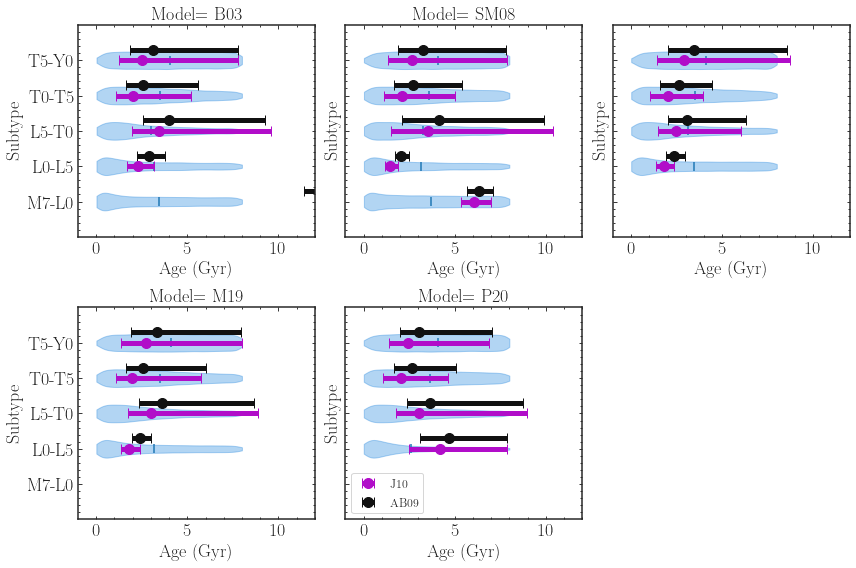

In [104]:



fig, ax=plt.subplots(figsize=(12, 8), ncols=3, nrows=2, sharex=False, sharey=True)
for model, a in zip(['burrows2001', 'baraffe2003', 'saumon2008','marley2019', 'phillips2020'], np.concatenate(ax)):

    ds=[]
    
    dfn=age_dictionaries[model].replace('T5-T9', 'T5-Y0')
    for k in age_tables_just[model].keys():
        if len(scale_height_dist[model][k]) <1:
            pass
        else:
            #empirical
            #ds0.append(age_tables_just[model][k])
            #from simulations
            ds.append(dfn.age[dfn.subtype==k].values)
    #some reformatting

    positions=[0, 1, 2, 3, 4]
    lolims=[0, 0, 0, 0, 0]
    if len(ds) ==4: positions=[1, 2, 3, 4]
    v1 = a.violinplot(ds,points=100, positions=positions,
               showmeans=True, showextrema=False, showmedians=False, vert =False)
    for b in v1['bodies']: 
          b.set_color('#0074D9')
        #get the center
    xerr0=np.vstack((age_tables_just[model].apply(lambda x: x[1]).values)).T
    xerr1=np.vstack((age_tables_sand[model].apply(lambda x: x[1]).values)).T
    xerr2=np.vstack((age_tables_aumer[model].apply(lambda x: x[1]).values)).T
    
    #set size of arrows
    xerr0.T[np.array(lolims).astype(bool)]=[0.5, 0.5]
    xerr1.T[np.array(lolims).astype(bool)]=[0.5, 0.5]
    xerr2.T[np.array(lolims).astype(bool)]=[0.5, 0.5]
    
    a.errorbar(age_tables_just[model].apply(lambda x: x[0]).values, [0, 1, 2, 3, 4],\
               xerr=xerr0,  fmt='o', label='J10', \
              ms=10, lw=5,  mfc='#B10DC9', mec='#B10DC9', ecolor='#B10DC9', capsize=5,
               xlolims=lolims)
    
    #a.errorbar(age_tables_yu[model].apply(lambda x: x[0]).values,  np.array([0, 1, 2, 3, 4])+0.2,\
    #           xerr=np.vstack((age_tables_yu[model].apply(lambda x: x[1]).values)).T,  fmt='o', label='Y18',
    #           ms=10, lw=5,  mfc='#B10DC9', mec='#B10DC9', ecolor='#B10DC9', capsize=5)
    
    #a.errorbar(age_tables_sand[model].apply(lambda x: x[0]).values,  np.array([0, 1, 2, 3, 4])+0.0,\
    #           xerr=xerr1,  fmt='o', label='SB15',
    #           ms=10, lw=5,  mfc='#B10DC9', mec='#B10DC9', ecolor='#B10DC9', capsize=5,
    #            xlolims=lolims)
    
    a.errorbar(age_tables_aumer[model].apply(lambda x: x[0]).values,  np.array([0, 1, 2, 3, 4])+0.30,\
               xerr=xerr2,  fmt='o', label='AB09',
               ms=10, lw=5,  mfc='#111111', mec='#111111', ecolor='#111111', capsize=5,
                xlolims=lolims)
    
    a.set_yticks([0, 1, 2, 3, 4])
    a.set_yticklabels(spgrid2)
    a.set_xlabel('Age (Gyr)', fontsize=18)
    a.set_ylabel('Subtype', fontsize=18)
    a.minorticks_on()
    a.set_xlim([-1, 12])
    a.set_ylim([-1, 5])
  
ax[0][0].set_title('Model= B03', fontsize=18)
ax[0][1].set_title('Model= SM08', fontsize=18)
ax[1][0].set_title('Model= M19', fontsize=18)
ax[1][1].set_title('Model= P20', fontsize=18)
ax[1][-2].legend(fontsize=12, loc='lower left')
fig.delaxes(np.concatenate(ax)[-1])
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/age_comparison.pdf', bbox_inches='tight',  \
            facecolor='white', transparent=True)

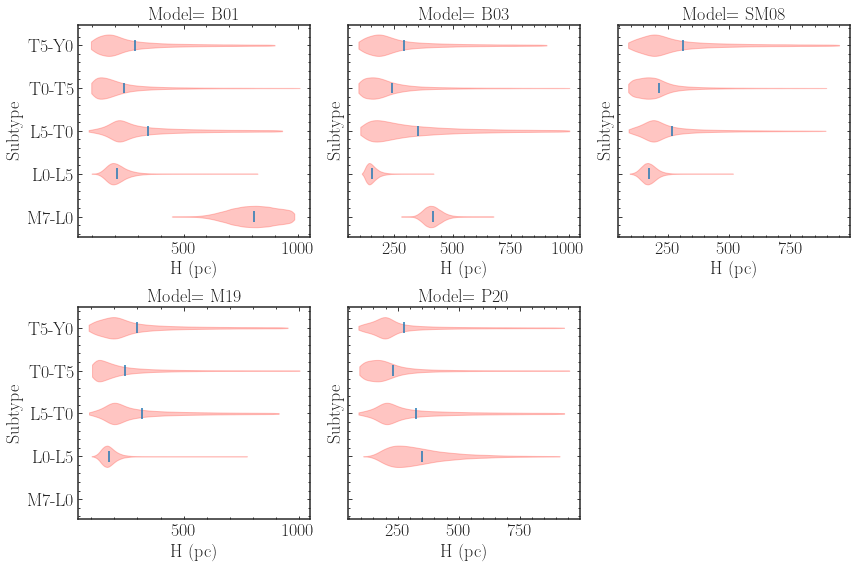

In [83]:
fig, ax=plt.subplots(figsize=(12, 8), ncols=3, nrows=2, sharex=False, sharey=True)

for model, a in zip([ 'burrows2001', 'baraffe2003', 'saumon2008','marley2019', 'phillips2020'], np.concatenate(ax)):
    ds=[]
    for k in scale_height_dist[model].keys():
        if len(scale_height_dist[model][k]) <1:
            pass
        else:
            ds.append(scale_height_dist[model][k])

    positions=[0, 1, 2, 3, 4]
    if len(ds) ==4: positions=[1, 2, 3, 4]
    v1 = a.violinplot(ds,points=100, positions=positions,
               showmeans=True, showextrema=False, showmedians=False, vert =False)
    for b in v1['bodies']: 
          b.set_color('#FF4136')
        #get the center
    a.set_yticks([0, 1, 2, 3, 4])
    a.set_yticklabels(spgrid2)
    a.set_xlabel('H (pc)', fontsize=18)
    a.set_ylabel('Subtype', fontsize=18)
    a.minorticks_on()

ax[0][0].set_title('Model= B01', fontsize=18)
ax[0][1].set_title('Model= B03', fontsize=18)
ax[0][2].set_title('Model= SM08', fontsize=18)
ax[1][0].set_title('Model= M19', fontsize=18)
ax[1][1].set_title('Model= P20', fontsize=18)

fig.delaxes(np.concatenate(ax)[-1])
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/scaleheight_comparison.pdf', bbox_inches='tight',  \
            facecolor='white', transparent=True)


In [84]:
#latex-readble 
#plt.hist(vel_df[model]['T0-T5'])

In [85]:
wisps.drop_nan(vel_df[model][k])

array([12.73445483, 12.6916237 ,  9.29076256, ..., 27.32502369,
        9.62664209, 21.7258829 ])

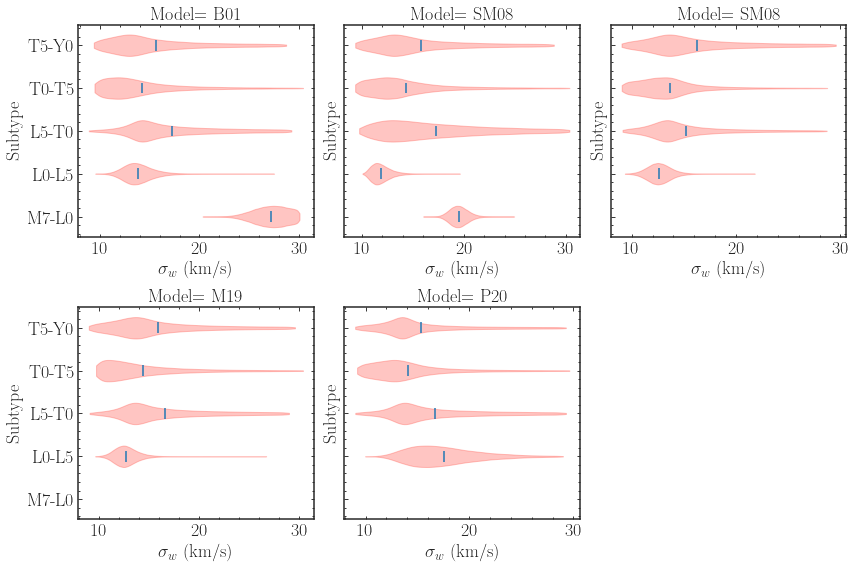

In [86]:
fig, ax=plt.subplots(figsize=(12, 8), ncols=3, nrows=2, sharex=False, sharey=True)
for model, a in zip(['burrows2001', 'baraffe2003', 'saumon2008','marley2019', 'phillips2020'], np.concatenate(ax)):
    ds=[]
    for k in vel_df[model].keys():
        if len(vel_df[model][k]) <1:
            pass
        else:
            ds.append(wisps.drop_nan(vel_df[model][k]))

    positions=[0, 1, 2, 3, 4]
    if len(ds) ==4: positions=[1, 2, 3, 4]
    v1 = a.violinplot(ds, points=100, positions=positions,
               showmeans=True, showextrema=False, showmedians=False, vert =False)
    for b in v1['bodies']: 
          b.set_color('#FF4136')
        #get the center
    a.set_yticks([0, 1, 2, 3, 4])
    a.set_yticklabels(spgrid2)
    a.set_xlabel(r'$\sigma _w$ (km/s)', fontsize=18)
    a.set_ylabel('Subtype', fontsize=18)
    a.minorticks_on()
    
ax[0][0].set_title('Model= B01', fontsize=18)
ax[0][1].set_title('Model= SM08', fontsize=18)
ax[0][2].set_title('Model= SM08', fontsize=18)
ax[1][0].set_title('Model= M19', fontsize=18)
ax[1][1].set_title('Model= P20', fontsize=18)
fig.delaxes(np.concatenate(ax)[-1])
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/velocity_comparison.pdf', bbox_inches='tight',  \
            facecolor='white', transparent=True)


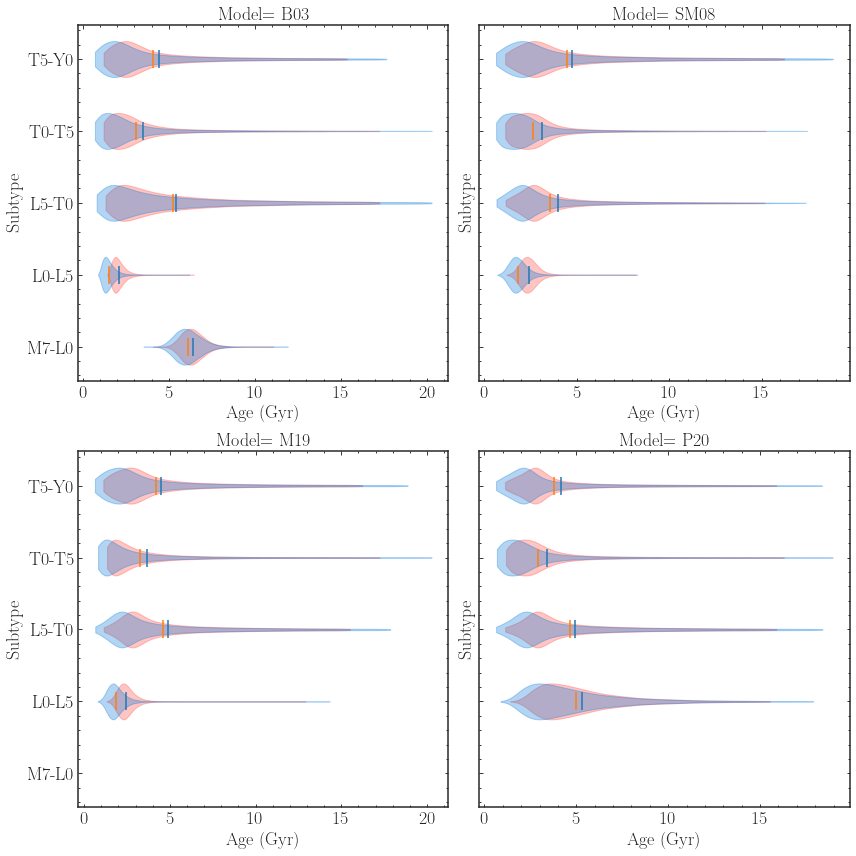

In [87]:
fig, ax=plt.subplots(figsize=(12, 12), ncols=2, nrows=2, sharex=False, sharey=True)
for model, a in zip([ 'baraffe2003', 'saumon2008','marley2019', 'phillips2020'], np.concatenate(ax)):
    ds=[]
    ds1=[]
    for k in vel_df[model].keys():
        if len(age_distdf_aumer[model][k]) <1:
            pass
        else:
            ds.append(age_distdf_aumer[model][k])
            ds1.append(age_distdf_just[model][k])

    positions=[0, 1, 2, 3, 4]
    if len(ds) ==4: positions=[1, 2, 3, 4]
    v1 = a.violinplot(ds,points=100, positions=positions,
               showmeans=True, showextrema=False, showmedians=False, vert =False)
    v2 = a.violinplot(ds1,points=100, positions=positions,
               showmeans=True, showextrema=False, showmedians=False, vert =False)
    for b in v1['bodies']: 
          b.set_color('#FF4136')
    for b in v2['bodies']: 
          b.set_color('#0074D9')
        #get the center
    a.set_yticks([0, 1, 2, 3, 4])
    a.set_yticklabels(spgrid2)
    a.set_xlabel(r'Age (Gyr)', fontsize=18)
    a.set_ylabel('Subtype', fontsize=18)
    a.minorticks_on()
ax[0][0].set_title('Model= B03', fontsize=18)
ax[0][1].set_title('Model= SM08', fontsize=18)
ax[1][0].set_title('Model= M19', fontsize=18)
ax[1][1].set_title('Model= P20', fontsize=18)
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/age_empirical_comparison.pdf', bbox_inches='tight',  \
            facecolor='white', transparent=True)

In [88]:
#scale_height_dist_df.apply(lambda x: np.concatenate(x.values), axis=0).apply(lambda x: \
#                            (np.nanmedian(x), 
#                            np.nanstd(x)))

In [89]:
#age_tables

In [90]:
scalh_tables.loc['M7-L0']['baraffe2003'][0]

411.76

In [91]:
v, unc=asssymetric_med_std(np.concatenate(scale_height_dist_df.loc['M7-L0'].values).flatten())

In [92]:
v

466.39

In [93]:
def get_median(df, subtype, rund=1):
    vs=np.concatenate(df.loc[subtype].values).flatten()
    val, unc=asssymetric_med_std(vs)
    res=''
    if np.isnan(val):
            res += ''
    else:
        if rund <1:
                st=str(int(np.round(val, rund)))+ '$_{-'+ str(int(np.round(unc[0], rund)))+'}'+\
                '^{+'+str(int(np.round(unc[1], rund)))+'} $&'
        else:
                st=str(np.round(val, rund))+ '$_{-'+ str(np.round(unc[0], rund))+'}'+\
                '^{+'+str(np.round(unc[1], rund))+'} $&'
        res += st
    
    return res
def get_formatted_string(df, subtype, rund=1):
    dn=df.loc[subtype]
    res=''
    for md in ['burrows2001', 'baraffe2003', 'saumon2008', 'marley2019', 'phillips2020' ]:
        val= dn[md][0]
        unc=dn[md][1]
        if np.isnan(val):
            res += '&'
        else:
            if rund <1:
                st=str(int(np.round(val, rund)))+ '$_{-'+ str(int(np.round(unc[0], rund)))+'}'+\
                '^{+'+str(int(np.round(unc[1], rund)))+'} $&'
            else:
                st=str(np.round(val, rund))+ '$_{-'+ str(np.round(unc[0], rund))+'}'+\
                '^{+'+str(np.round(unc[1], rund))+'} $&'
            res += st
    return res

In [100]:
get_median(scale_height_dist_df, subtype, rund=0)

'225$_{-83}^{+273} $&'

In [98]:
#print latex formatted 
for idx, subtype in enumerate(spgrid2):
    print (subtype + r'&$H$ (pc) &' + get_formatted_string(scalh_tables, subtype, rund=0) \
           + get_median(scale_height_dist_df, subtype, rund=0) + '&'+ \
           str(int(np.round(y2)[idx]))+ r'\\ ')
    print (r' & $\sigma_w$ (km/s)  &' + get_formatted_string(vel_tables, subtype) \
           + get_median(vel_df, subtype) + '&'+ r'\\ ')
    print (r' & Age (Gyr) (J10) &' + get_formatted_string(age_tables_just, subtype) \
           + get_median(age_distdf_just, subtype)+ '&' + r'\\ ')
    #print (r' & Age (Gyr) (SB15)&' + get_formatted_string(age_tables_sand, subtype)  \
    #       + get_median(age_distdf_sand, subtype) + r'\\ ')
    #print (r' & Age (Gyr) (Y18)&' + get_formatted_string(age_tables_yu, subtype)  \
    #       + get_median(age_distdf_yu, subtype) + r'\\ ')
    print (r' & Age (Gyr) (A09)&' + get_formatted_string(age_tables_aumer, subtype)  \
           + get_median(age_distdf_aumer, subtype)+ '&' + r'\\ ')

M7-L0&$H$ (pc) &809$_{-115}^{+113} $&412$_{-37}^{+44} $&&&&466$_{-78}^{+397} $&&107\\ 
 & $\sigma_w$ (km/s)  &27.3$_{-2.0}^{+1.8} $&19.5$_{-0.9}^{+1.0} $&&&&20.7$_{-1.8}^{+7.5} $&&\\ 
 & Age (Gyr) (J10) &15.2$_{-2.8}^{+2.9} $&6.1$_{-0.7}^{+0.9} $&&&&7.2$_{-1.6}^{+9.4} $&&\\ 
 & Age (Gyr) (A09)&13.6$_{-2.2}^{+2.1} $&6.3$_{-0.6}^{+0.8} $&&&&7.3$_{-1.4}^{+7.3} $&&\\ 
L0-L5&$H$ (pc) &204$_{-39}^{+55} $&149$_{-20}^{+31} $&172$_{-30}^{+36} $&173$_{-29}^{+38} $&315$_{-99}^{+183} $&183$_{-40}^{+99} $&&13\\ 
 & $\sigma_w$ (km/s)  &13.7$_{-1.4}^{+1.8} $&11.7$_{-0.8}^{+1.2} $&12.6$_{-1.2}^{+1.2} $&12.6$_{-1.1}^{+1.3} $&17.0$_{-2.9}^{+4.4} $&13.0$_{-1.5}^{+3.1} $&&\\ 
 & Age (Gyr) (J10) &2.3$_{-0.6}^{+0.9} $&1.4$_{-0.3}^{+0.5} $&1.8$_{-0.4}^{+0.6} $&1.8$_{-0.4}^{+0.6} $&4.2$_{-1.7}^{+3.7} $&2.0$_{-0.6}^{+1.7} $&&\\ 
 & Age (Gyr) (A09)&2.9$_{-0.6}^{+0.9} $&2.0$_{-0.3}^{+0.5} $&2.4$_{-0.5}^{+0.6} $&2.4$_{-0.4}^{+0.6} $&4.7$_{-1.6}^{+3.2} $&2.6$_{-0.6}^{+1.6} $&&\\ 
L5-T0&$H$ (pc) &272$_{-87}^{+305} 

In [ ]:
#get_median(scale_height_dist_df, subtype)

In [ ]:
all_ages_simulations=[] 
for model in [ 'baraffe2003', 'saumon2008','marley2019', 'phillips2020']:
    all_ages_simulations.append(age_dictionaries[model][['age', 'spt']])

In [ ]:
all_ages_sim_df=pd.concat(all_ages_simulations)

In [ ]:
from pprint import pprint

In [ ]:
for model in ['baraffe2003', 'saumon2008','marley2019', 'phillips2020']:
    for subtype in [ 'M7-L0','L0-L5', 'L5-T0', 'T0-T5', 'T5-Y0']:
        dfn=age_dictionaries[model].replace('T5-T9', 'T5-Y0')
        x=dfn[dfn.subtype ==subtype].age.values
        y=age_distdf_aumer[model][subtype]
        yx=age_distdf_just[model][subtype]
        #fig, ax=plt.subplots()
        #h=plt.hist(x, density=True)
        #h=plt.hist(y, density=True)
        if len(y)==0:
            pass
        else:
            print (model, subtype)
            pprint(stats.ks_2samp(x, y, mode='asymp', alternative='two-sided'))
            pprint(stats.ks_2samp(x, yx, mode='asymp', alternative='two-sided'))
            #print (stats.anderson_ksamp(np.array([np.random.choice(x, 100),\
            #                                      np.random.choice(y, 100)])))
    print ('------------------------')

In [ ]:
y2
